# Exciton-Polaritons in Lattices

**by Dmitry R. Gulevich <br>
ITMO University, St Petersburg, Russia**

Python code to simulate exciton-polaritons in lattices.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import exp2d
%matplotlib inline

In [91]:
import imp
imp.reload(exp2d)

<module 'exp2d' from '/home/dimitry/Desktop/RESEARCH 2018/SpinorGP code/exp2d/exp2d.py'>

# 1. Setting up the model

In [4]:
me=9.1e-31 # electron mass, kg
meff=5.0e-5*me # exciton-polariton effective mass, kg
hbar=1.05e-34 # reduced Planck constant, J s
dum=3. # micron
d=dum*1.e-6 # m
E0=hbar*hbar/(2.*meff*d*d)/(1.6e-22) # characteristic energy, meV
print('E0 = %f meV' % E0)

E0 = 0.084135 meV


In [5]:
M=20 # should be even number
assert M%2==0
Mhalf=round(M/2)
Umax=20. # height of the potential
aum = 2.9 # um
dum = 3.0 # um
Rpillar=0.5*dum/(2.*aum) # in units of lattice constant

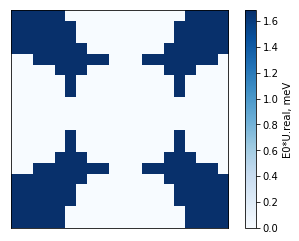

In [6]:
dr=1./M
dr2=dr*dr

U = Umax*exp2d.U_Lieb(M,Rpillar) # create potential

cmap=plt.get_cmap('Blues')
data=E0*U.real
img=plt.imshow(data.T,interpolation='nearest', cmap = cmap, origin='lower')
plt.xticks([])
plt.yticks([])
plt.colorbar(img,cmap=cmap,label='E0*U.real, meV')
plt.show()

# 2. Band structure and eigenstates

In [7]:
# Calculate eigenenergies for ky=np.pi, NBzones=2, Nvals=30, Nkpoints=70
%time kxrange,evlist=exp2d.calc_bands(M, U, np.pi, 2, 30, 70)

CPU times: user 3.24 s, sys: 23.1 ms, total: 3.26 s
Wall time: 1.65 s


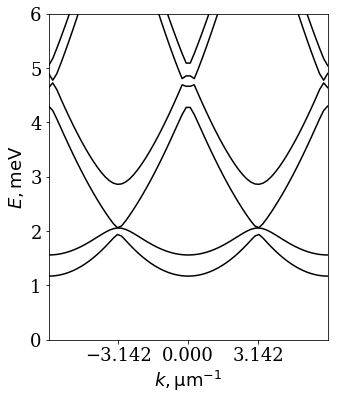

In [87]:
### Source: cbands.py

plt.rc('font', family='serif', size=18)
fig, ax = plt.subplots(figsize=(5,6))

for i in range(evlist.shape[1]):
    ax.plot(kxrange,E0*evlist[:,i],'k')

ax.set_xlim([kxrange[0],kxrange[-1]])
ax.set_ylim([0,6])
ax.set_xlabel(r"$k, \rm \mu m^{-1}$")
ax.set_ylabel(r"$E, \rm meV$")
ax.set_xticks([-np.pi,0,np.pi])
plt.show()

In [9]:
evals,evecs = exp2d.calc_vectors(M, U, np.pi, np.pi, 30)

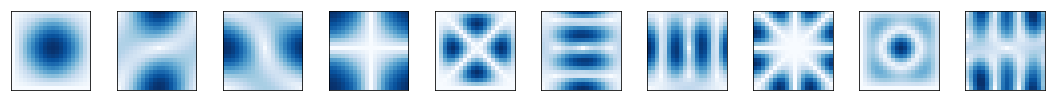

In [10]:
nvmax=10 # number of eigenvectors to display
plt.rc('font', family='serif', size=18)
fig, ax = plt.subplots(1,nvmax,figsize=(15,2))

cmap=plt.get_cmap('Blues')

for nv in range(nvmax):
    data=np.abs(evecs[nv]).reshape(M,M)
    ax[nv].imshow(data.T,interpolation='nearest', cmap = cmap, origin='lower')
    ax[nv].set_xticks([])
    ax[nv].set_yticks([])

plt.tight_layout()
plt.show()

# 3. Dynamics

In [76]:
nv=4
Ncells=8 # integer number for symmetric display
Mglobal=Ncells*M

Uglobal=np.zeros((Mglobal,Mglobal),dtype=np.complex128)
for i in range(Ncells):
    for j in range(Ncells):
        Uglobal[i*M:(i+1)*M,j*M:(j+1)*M] = U[:,:]
        
Psi=np.zeros((Ncells*M,Ncells*M),dtype=np.complex128)

kx=0.
ky=0.
evals,evecs = exp2d.calc_vectors(M, U, kx, ky, 30)

psi=evecs[nv].reshape(M,M)


for i in range(Ncells):
    for j in range(Ncells):
        Psi[i*M:(i+1)*M,j*M:(j+1)*M] = psi[:,:]*np.exp(1j*(kx*i+ky*j))

print('# Initialized at kx=%f, ky=%f, nv=%d' % (kx,ky,nv))

# Initialized at kx=0.000000, ky=0.000000, nv=4


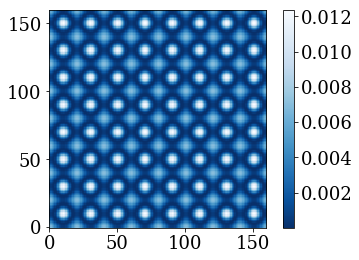

In [77]:
interpolation='nearest'
#interpolation='gaussian'
#interpolation=None
cmap=plt.get_cmap('Blues_r')
data=(Psi*np.conjugate(Psi)).real
img=plt.imshow(data.T,interpolation=interpolation, cmap = cmap, origin='lower')
plt.colorbar(img,cmap=cmap)
plt.show()

In [78]:
import time
from scipy.sparse import csc_matrix
from scipy.sparse import dia_matrix
from scipy.sparse import linalg

Nvals=30
#Emax=4. # meV
nvrange=range(10)
dk=2.*np.pi/Ncells

### Constructing matrix

Imat=np.ones(M*M,dtype=np.complex128)
Itop=np.ones(M,dtype=np.complex128)
Itop[0]=0.
Itopmat=np.array([Itop]*M).ravel()
Ibot=np.ones(M,dtype=np.complex128)
Ibot[-1]=0.
Ibotmat=np.array([Ibot]*M).ravel()

offset=[-(M-1),-M*(M-1),-M,-1,0,1,M,M*(M-1),M-1]
u=np.empty((M,M),dtype=np.complex128)

Psi=np.zeros((Ncells*M,Ncells*M),dtype=np.complex128)

start_time = time.time()

# Loop over BZ
for n in range(Ncells):
#for n in [int(Ncells/2)]:
    ky=-np.pi+n*dk

    eky=np.exp(-1j*ky)
    ekytop=np.zeros(M,dtype=np.complex128)
    ekybot=np.zeros(M,dtype=np.complex128)
    ekytop[-1]=-eky
    ekybot[0]=-np.conjugate(eky)
    topmat=np.array([ekytop]*M).ravel()
    botmat=np.array([ekybot]*M).ravel()

    for m in range(Ncells):

        # skip G and K points
        #if((n==int(Ncells/2) and m==int(Ncells/2)) or (n==0 and m==0)):
        #    continue

        kx=-np.pi+m*dk
        ekx=np.exp(-1j*kx)
        data=[botmat,-Imat*np.conjugate(ekx),-Imat,-Ibotmat,4.*Imat + dr2*U.real.ravel(),-Itopmat,-Imat,-Imat*ekx,topmat]
        dmatrix=dia_matrix((data, offset), shape=(M*M, M*M))
        spmatrix=csc_matrix(dmatrix)
        evalsunsorted,Tevecs=linalg.eigsh(spmatrix, return_eigenvectors=True, k=Nvals, sigma=0)
        evalsunsorted/=dr2
        evecsunsorted=Tevecs.T

        inds=np.argsort(evalsunsorted)
        evals=evalsunsorted[inds]
        evecs=evecsunsorted[inds]
        ens=E0*evals

        #print('Energies in meV:')
        #print(ens)

        for nv in nvrange:

            if(ens[nv]<=Emax):
                
                vec=np.copy(evecs[nv])

#                ind=np.argmax(vec*np.conjugate(vec))                
#                factor=vec[ind]/np.abs(vec[ind])
#                vec*=np.conjugate(factor)

                psi=vec.reshape(M,M)

                randphase = np.exp(1j*2.*np.pi*np.random.random_sample())
#                randphase = 1. ### debug

                '''
                for i in range(M):
                    for j in range(M):
                        u[i,j]=psi[i,j]*np.exp(-1j*dr*(kx*i+ky*j))

                for i in range(M*Ncells):
                    for j in range(M*Ncells):
                        Psi[i,j] += randphase*u[i%M,j%M]*np.exp(1j*dr*(kx*i+ky*j))
                '''

                for i in range(Ncells):
                    for j in range(Ncells):
                        Psi[i*M:(i+1)*M,j*M:(j+1)*M] += randphase*psi*np.exp(1j*(kx*i+ky*j))


In [92]:
from numpy.ctypeslib import ndpointer, load_library
from ctypes import *

### === C library interface ===
libcd = load_library("liblattice.so", ".")
libcd.lattice.restype = None
libcd.lattice.argtypes = [ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
        ndpointer(dtype=np.complex128, ndim=3, flags='C_CONTIGUOUS'),
        c_int, c_int, c_double, c_double, c_int, c_int,
        ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS')]

libcd.omp_set_num_threads(2) # set number of OpenMP threads

'''
#dt=0.002
dt=0.001
dtout=0.05
tstart=0.
countout=int(dtout/dt)
Nframes=50
NPKY=6
'''

dt=0.001
dtout=0.05
tstart=0.
countout=int(dtout/dt)
Nframes=50
NPKY=6

FPsiarr=np.empty((Nframes,NPKY,Mglobal),dtype=np.complex128)

%time libcd.lattice(Psi,FPsiarr,Ncells,Mhalf,tstart,dt,Nframes,countout,Uglobal)

CPU times: user 7.02 s, sys: 0 ns, total: 7.02 s
Wall time: 7.02 s


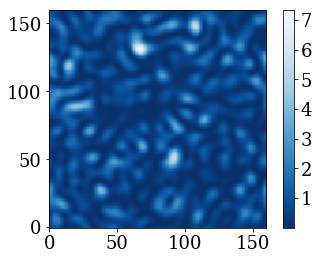

In [93]:
interpolation='nearest'
cmap=plt.get_cmap('Blues_r')
data=(Psi*np.conjugate(Psi)).real
img=plt.imshow(data.T,interpolation=interpolation, cmap = cmap, origin='lower')
plt.colorbar(img,cmap=cmap)
plt.show()

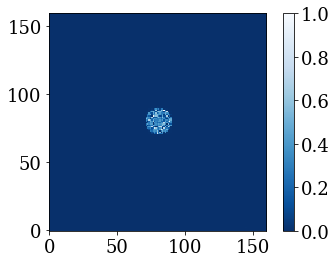

In [94]:
interpolation='nearest'
#interpolation='gaussian'
#interpolation=None

vmax=1
FPsi=np.fft.fftshift(np.fft.fft2(Psi))

cmap=plt.get_cmap('Blues_r')
Rho=(FPsi*np.conjugate(FPsi)).real
data=Rho/np.max(Rho)
#extent=[-0.5*dk*Mglobal/dum,0.5*dk*Mglobal/dum,-0.5*dk*Mglobal/dum,0.5*dk*Mglobal/dum]
#img=plt.imshow(data.T,interpolation=interpolation, cmap = cmap, origin='lower',extent=extent, vmax=vmax)
img=plt.imshow(data.T,interpolation=interpolation, cmap = cmap, origin='lower', vmax=vmax)
plt.colorbar(img,cmap=cmap)
plt.show()

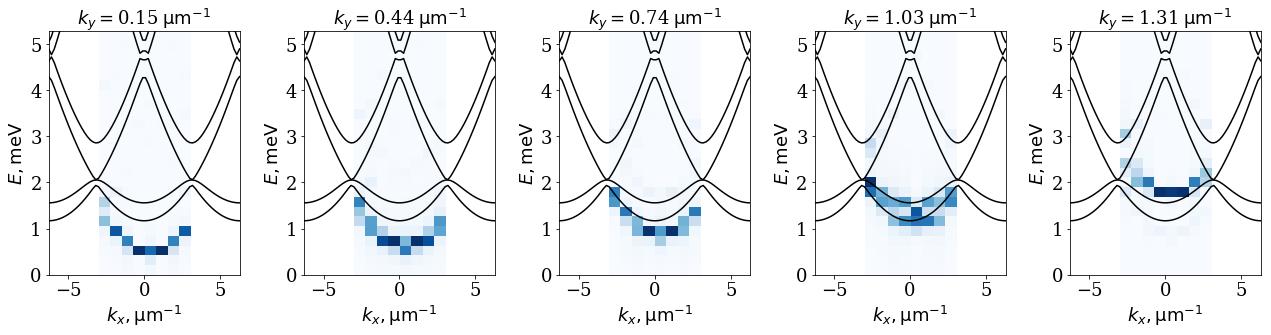

In [96]:
plt.rc('font', family='serif')
plt.rc('font', size='18')

kylist_local=np.array([0., 0.15, 0.44, 0.74, 1.03, 1.31]);

fig, ax = plt.subplots(1, 5, figsize=(18,5))

from matplotlib.colors import LinearSegmentedColormap
cdict = {'red':   ((0.0, 1.0, 1.0),
                   (0.3, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.3, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 0.8, 0.8)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.3, 0.5, 0.5),
                   (0.75, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

#cmap = LinearSegmentedColormap('mycmap', cdict)
cmap=plt.get_cmap('Blues')

vmax=1.
Lx=Ncells
dkx=2.*np.pi/Lx;

Ntstart=int(0.*Nframes)
Ntfinish=int(1*Nframes)


for Pky in [1,2,3,4,5]:
#for Pky in [2]:
    i=Pky-1

    fftarr=np.fft.fftshift(np.fft.fft(FPsiarr[Ntstart:Ntfinish,Pky,:],axis=0),axes=1)
    Nframecut=fftarr.shape[0]

    data=(fftarr*np.conjugate(fftarr)).real
    data1=data[::-1]

    dE=2.*np.pi*E0/(Nframecut*dtout)
    Emax=0.5*Nframecut*dE

    data2=data1[0:int(0.5*Nframecut),int(Mglobal*0.5-kmax/dkx):int(Mglobal*0.5+kmax/dkx)+1]   
    data3=data2/np.max(data2)
    img=ax[i].imshow(data3,aspect='auto', interpolation='nearest', extent=[-kmax,kmax,0,Emax], cmap = cmap, 
                     origin='lower',vmax=vmax)
    #img=ax.imshow(data3,aspect='auto', extent=[-kmax,kmax,0,Emax], cmap = cmap, origin='lower',vmax=vmax)
    #img=ax.imshow(data3,aspect='auto', cmap = cmap, origin='lower')
    #img=imshow(data[::-1], aspect='auto', cmap = cmap, origin='lower',vmax=vmax)
    #colorbar(img,cmap=cmap)
    ax[i].set_xlabel("k")
    #ax[i].set_xticks([-2,-1,0,1,2])
    
    ax[i].set_title(r'$k_y=$'+str(kylist_local[Pky])+r'$\rm\; \mu m^{-1}$', fontsize=18)

ax[0].set_ylabel("E, meV")
#fig.subplots_adjust(hspace=0.8)

cmap=plt.get_cmap('Blues')

### ---  Band Structure ---

for nax in range(5):
    for i in range(evlist.shape[1]):
        ax[nax].plot(kxrange,E0*evlist[:,i],'k')  

    ax[nax].set_xlim([kxrange[0],kxrange[-1]])
    ax[nax].set_ylim([0,Emax])
    ax[nax].set_xlabel(r"$k_x, \rm \mu m^{-1}$")
    ax[nax].set_ylabel(r"$E, \rm meV$")
    #ax[nax].set_xticks([-2,-1,0,1,2])

plt.tight_layout()

plt.show()